# Grad-cam folder
This notebook implements the grad-cam algorithm presented in the paper [Grad-CAM: Visual Explanations from Deep Networks
via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf). Grad-Cam provide a useful tool to understand which region of the model are used to make predictions.  
  
The code is an adaptation of the code example from the officiel Keras website: [Grad-CAM class activation visualization](https://keras.io/examples/vision/grad_cam/)  
Author: [fchollet](https://twitter.com/fchollet)  
Update: Colin Pelletier, Joris Monnet and Kilian Raude

In [ ]:


display(Image(img_path))

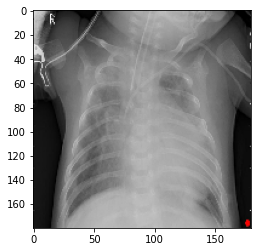

In [ ]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from tqdm import tqdm
import json
import codecs
import sys
from keras.layers import Flatten
from keras.models import Model


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# My own functions and classes used to create the model and preprocess the images

#
# Image import and pre-processing
#
class ImageTools:

    def __init__(self, image_size, num_parallel_calls, normal_folder_name):
        """

        """
        self.image_size = image_size
        self.num_parallel_calls = num_parallel_calls
        self.normal_folder_name = normal_folder_name


    def get_label(self, file_path):
        """

        """
        # convert the path to a list of path components
        label_part = tf.strings.split(file_path, os.path.sep)[-3]
        # print(label_part.take(0))
        # label_part = label_part.numpy()
        # convert the numpy byte array to a string
        # return 'Normal' not in label_part.decode('UTF-8')
        return label_part != self.normal_folder_name


    def decode_img(self, img):
        """

        """
        # convert the compressed string to a 3D uint8 tensor
        img = tf.image.decode_jpeg(img, channels=3)
        # Use `convert_image_dtype` to convert to floats in the [0,1] range.
        img = tf.image.convert_image_dtype(img, tf.float32)
        # resize the image to the desired size.
        return tf.image.resize(img, self.image_size)


    def process_path(self, file_path):
        """

        """
        label = self.get_label(file_path)
        # load the raw data from the file as a string
        img = tf.io.read_file(file_path)
        img = self.decode_img(img)
        return img, label

    
    def load_images_from_filenames(self, ds):
        """

        """
        return ds.map(self.process_path, num_parallel_calls=self.num_parallel_calls)


#
# Batch import
#

def prepare_for_training(ds, batch_size, buffer_size, cache=True, shuffle_buffer_size=1000):
    """

    """
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(batch_size)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    #ds = ds.prefetch(buffer_size=AUTOTUNE) TODO remove it
    ds = ds.prefetch(buffer_size=buffer_size)

    return ds


def conv_block(filters):
    """

    """
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    """

    """
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model(image_size):
    """
        Text from the notebook
        The following method will define the function to build our model for us.
        The Dropout layers are important as they "drop out," hence the name,
        certain nodes to reduce the likelikhood of the model overfitting. 
        We want to end the model with a Dense layer of one node, as this will 
        be the output that determines if an X-ray shows an image of pneumonia.
    """
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(image_size[0], image_size[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model


#
# FINETUNING
#

def exponential_decay(lr0, s):
    """

    """
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn


#
# VISUALIZATION
#

def plot_model_performances(history, metrics=['precision', 'recall', 'accuracy', 'loss'], suptitle='Model Metrics', figsize=(20, 3)):
    """

    """
    fig, ax = plt.subplots(1, 4, figsize=figsize)
    ax = ax.ravel()

    for i, metric in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history.history[metric])
        ax[i].plot(history.history['val_' + metric])
        ax[i].set_title('Model {}'.format(metric))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(metric)
        ax[i].legend(['train', 'val'])
    plt.plot()


#
# EXPORT
#

def save_history(filename, history_dict):
    """

    """
    # make sure to cast float32 values to string
    for key, lst in history_dict.items():
        history_dict[key] = [str(val) for val in lst]

    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(history_dict, f)
        print("History successfully written in {}".format(filename))
        


def load_history(filename):
    """

    """
    with open(filename, 'r', encoding='utf-8') as f:
        history_dict = json.load(f)

        # cast string values to float32
        for key, lst in history_dict.items():
            history_dict[key] = [np.float32(val) for val in lst]


def predict_and_save_predictions(model, test_ds_batch, test_filenames, filename):
    """

    """
    # TODO improve that

    # predict and get predicted label by applying a threshold
    y_pred = model.predict(test_ds_batch)
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
    y_pred = y_pred.astype(np.int32)

    y_true = np.array(['Normal' in name for name in test_filenames]).astype(np.int32)

    with open(filename, encoding='utf-8', mode='w') as f:
        #y_true;y_pred
        for i in range(y_true.shape[0]):
            f.write("{};{}\n".format(y_true[i], y_pred[i][0]))

        print("Predictions successfully written in {}".format(filename))



img_size = [180, 180]
img_path = './person1_virus_6.jpeg'
# model_file = './drive/MyDrive/ml-project-2-la_team/generated/dot_model/dot_xray_model.h5'
model_file = './dot_xray_model.h5'
AUTOTUNE = tf.data.experimental.AUTOTUNE

im_tools = ImageTools(img_size, AUTOTUNE, 'Normal_dot')
img, label = im_tools.process_path(img_path)
img_input = tf.expand_dims(img, axis=0)


model_file = './drive/MyDrive/ml-project-2-la_team/generated/date_model/dot_xray_model.h5'

# Make model
base_model = keras.models.load_model(model_file)

gradcam_model = tf.keras.models.Model(
    inputs=[base_model.inputs], 
    outputs=[base_model.layers[8].output, base_model.output]
    )

# function from the tutorial
def make_gradcam_heatmap(img_array, model, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs], 
        # outputs=[model.get_layer(last_conv_layer_name).output, model.output]
        outputs=[model.layers[-5].output, model.output]
        )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_input, gradcam_model)

# Display heatmap
plt.matshow(heatmap)
plt.show()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 sequential_8 (Sequential)   (None, 45, 45, 32)        2160      
                                                                 
 sequential_9 (Sequential)   (None, 22, 22, 64)        7392      
                                                                 
 sequential_10 (Sequential)  (None, 11, 11, 128)       27072     
                                                     

In [ ]:
# all layers before flatten are convolutions
gradcam_model = tf.keras.models.Model(
    inputs=[base_model.inputs], 
    outputs=[base_model.layers[8].output, base_model.output]
    )

gradcam_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 sequential_8 (Sequential)   (None, 45, 45, 32)        2160      
                                                                 
 sequential_9 (Sequential)   (None, 22, 22, 64)        7392      
                                                           

In [ ]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_input, gradcam_model)

# Display heatmap
plt.matshow(heatmap)
plt.show()

TypeError: ignored

## Create a superimposed visualization

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

## Let's try another image

We will see how the grad cam explains the model's outputs for a multi-label image. Let's
try an image with a cat and a dog together, and see how the grad cam behaves.

In [ ]:
img_path = keras.utils.get_file(
    "cat_and_dog.jpg",
    "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",
)

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

We generate class activation heatmap for "chow," the class index is 260heatmap for "chow," the class index is 260

In [ ]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=260)

save_and_display_gradcam(img_path, heatmap)

We generate class activation heatmap for "egyptian cat," the class index is 285

In [ ]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=285)

save_and_display_gradcam(img_path, heatmap)